In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class KArmedBandit:
    """ Classe para representar uma máquina caça níquel ou Armed Bandit """
    n_arms: int # Número de braços da máquina
    arm_values: list[float] # Valor médio que cada braço retorna ao ser acionado
    def __init__(self, n_arms: int) -> None:
        self.n_arms = n_arms
        self.arm_values = []
        for i in range(self.n_arms):
            self.arm_values.append(3) # iniciamos todos com 3, como pedido pelo exercício
    def activate(self, action: int) -> float:
        """ Retorna uma recompensa gerada pela distribuição em torno do valor médio
        e também modifica todos os valores de cada alavanca para tornar o problema não
        estacionário """
        reward = np.random.normal(self.arm_values[action], 1)
        for i in range(self.n_arms):
            self.arm_values[i] += np.random.normal(0, 0.01)
        return reward

In [3]:
class Model:
    """ Classe para representar um modelo básico de um agente ε-Guloso """
    epsilon: float
    estimate_list: list[float]
    n_actions: list[int]
    def __init__(self, n_arms: int, epsilon: float) -> None:
        self.epsilon = epsilon
        self.estimate_list = []
        self.n_actions = []
        for i in range(n_arms):
            self.estimate_list.append(0)
            self.n_actions.append(0)

    def decide(self) -> int:
        """ O agente utiliza sua lista de estimativas e o seu valor ε para decidir
        qual ação tomará em seguida """
        random = np.random.random()
        if random < self.epsilon:
            return np.random.randint(0, len(self.estimate_list) - 1)
        else:
            return int(np.argmax(self.estimate_list))

    def learn(self, action: int, reward: float) -> None:
        """ Após obter feedback do Bandit, o agente aprende utilizando média de samples"""
        self.n_actions[action] += 1
        self.estimate_list[action] += (reward - self.estimate_list[action]) / self.n_actions[action]

In [4]:
class ModelStepSize(Model):
    """ Modelo para um agente ε-Guloso que pode utilizar constant step-size parameter
    para dar mais peso aos novos feedbacks, assim se adaptando melhor a ambientes não
    estacionários """
    alpha: float

    def __init__(self, n_arms: int, epsilon: float, alpha: float) -> None:
        super().__init__(n_arms, epsilon)#%%
        self.alpha = alpha

    def learn(self, action: int, reward: float) -> None:
        """ Após obter feedback do Bandit, o agente aprende utilizando parâmetro de passo constante """
        self.n_actions[action] += 1
        self.estimate_list[action] += self.alpha * (reward - self.estimate_list[action])



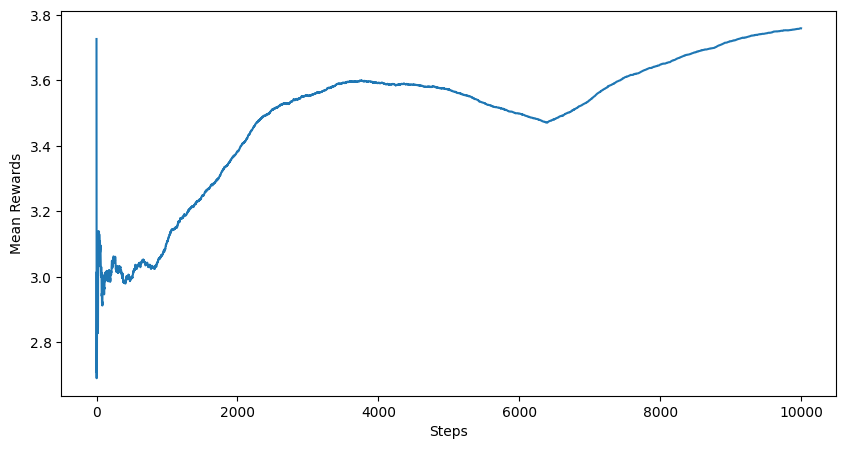

In [5]:
bandits = KArmedBandit(10)
modelo = Model(10, 0.1)
score = [0]
means = []
for step in range(10_000):
    action_i = modelo.decide()
    reward_i = bandits.activate(action_i)
    modelo.learn(action_i, reward_i)
    score.append(score[-1] + reward_i)
    means.append(score[-1]/(step+1))
plt.figure(figsize=(10, 5))
plt.plot(means)
plt.xlabel("Steps")
plt.ylabel("Mean Rewards")
plt.show()

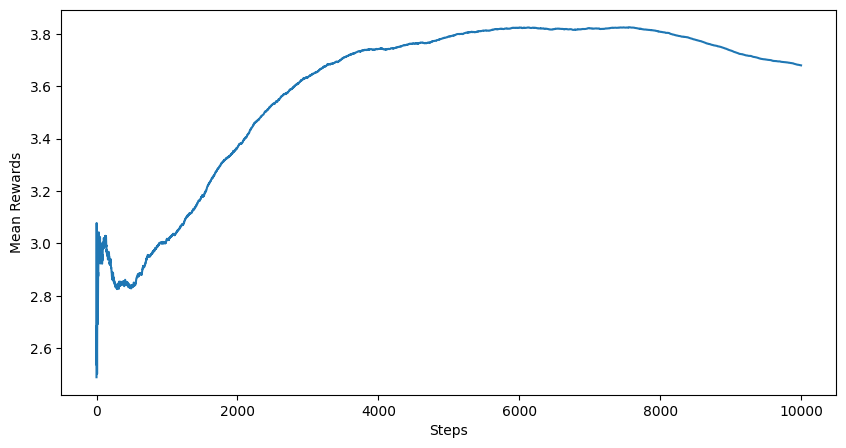

In [6]:
bandits = KArmedBandit(10)
modeloAlpha = ModelStepSize(10, 0.1, 0.1)
score = [0]
means = []
for step in range(10_000):
    action_i = modeloAlpha.decide()
    reward_i = bandits.activate(action_i)
    modeloAlpha.learn(action_i, reward_i)
    score.append(score[-1] + reward_i)
    means.append(score[-1]/(step+1))
plt.figure(figsize=(10, 5))
plt.plot(means)
plt.xlabel("Steps")
plt.ylabel("Mean Rewards")
plt.show()

In [7]:
def teste_agente_guloso(n_steps: int, n_sim: int, n_arms: int, epsilon: float) -> list[float]:
    total_means = []
    for sim in range(n_sim):
        score = [0]
        means = []
        modelo = Model(n_arms, epsilon)
        bandits = KArmedBandit(n_arms)
        for step in range(n_steps):
            action_i = modelo.decide()
            reward_i = bandits.activate(action_i)
            modelo.learn(action_i, reward_i)
            score.append(score[-1] + reward_i)
            means.append(score[-1]/(step+1))
        total_means.append(means)
    return total_means
def teste_agente_guloso_cte(n_steps: int, n_sim: int, n_arms: int, epsilon: float, alpha: float) -> list[float]:
    total_means = []
    for sim in range(n_sim):
        score = [0]
        means = []
        modelo = ModelStepSize(n_arms, epsilon, alpha)
        bandits = KArmedBandit(n_arms)
        for step in range(n_steps):
            action_i = modelo.decide()
            reward_i = bandits.activate(action_i)
            modelo.learn(action_i, reward_i)
            score.append(score[-1] + reward_i)
            means.append(score[-1]/(step+1))
        total_means.append(means)
    return total_means

In [8]:
e_guloso = teste_agente_guloso(10_000, 200, 10, 0.1)
alpha_guloso = teste_agente_guloso_cte(10_000, 200, 10, 0.1, 0.1)

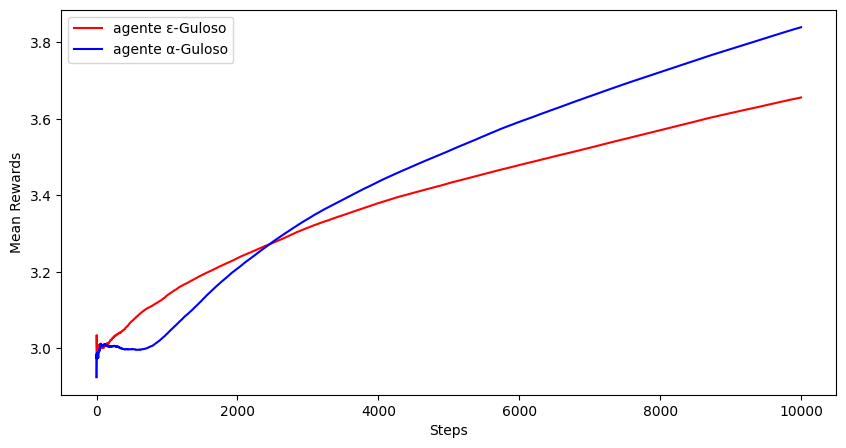

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(e_guloso, axis=0), c="red", label="agente ε-Guloso")
plt.plot(np.mean(alpha_guloso, axis=0), c="blue", label="agente α-Guloso")
plt.xlabel("Steps")
plt.ylabel("Mean Rewards")
plt.legend(loc="best")
plt.show()

# Análise
É possível perceber que o agente ε-Guloso comum teve muitas dificuldades em se adaptar ao sistema não estacionário, isto é, quando os rewards médios de cada alavanca variava no tempo, provavelmente por assumir peso igual a todos os eventos anteriores, enquanto o agente com parâmetro de passo constante atribui peso maior para eventos mais recentes, assim se adaptando e tendo melhor desempenho